In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import catboost as catb

In [2]:
%matplotlib inline

In [3]:
data = pd.read_csv('course_project_train.csv')
X_test = pd.read_csv('course_project_test.csv')

In [4]:
X_test = pd.read_csv('course_project_test.csv')

In [5]:
train, valid = train_test_split(data, test_size=0.25, random_state=21)

Функции:

In [6]:
def modify_data(df, median_annual_income, median_accounts, median_months_delinquent, median_years_history, median_max_credit, 
                median_current_credit_balance, median_monthly_debt, median_bankruptcies):
    
    df.loc[df['Bankruptcies'].isnull(), 'Bankruptcies'] = median_bankruptcies
    df.loc[df['Annual Income'] > 5*10**6, 'Annual Income'] = median_annual_income
    df.loc[df['Number of Open Accounts'] > 30, 'Number of Open Accounts'] = median_accounts
    df.loc[df['Months since last delinquent'] > 100, 'Months since last delinquent'] = median_months_delinquent
    df.loc[df['Years of Credit History'] > 45, 'Years of Credit History'] = median_years_history
    df.loc[df['Maximum Open Credit'] > 10**7, 'Maximum Open Credit'] = median_max_credit
    df.loc[df['Current Credit Balance'] > 3*10**6, 'Current Credit Balance'] = median_current_credit_balance
    df.loc[df['Monthly Debt'] > 70000, 'Monthly Debt'] = median_monthly_debt
    
    df['Short Term'] = (df['Term'] == 'Short Term').astype(int)
    df = df.drop('Term', axis=1)

In [7]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [8]:
def get_balance(df, target_name):
    
    target_counts = df[target_name].value_counts()
    
    target_class_1 = target_counts.argmax()
    target_class_0 = target_counts.argmin()
    
    coeff = int(target_counts[target_class_1] / target_counts[target_class_0]) - 1
    
    for _ in range(coeff):
        add_sample = df[df[target_name] == target_class_0].sample(frac=1)
        df = df.append(add_sample, ignore_index=True)
    
    return df.sample(frac=1)    

In [9]:
def show_proba_calibration(y_pred_proba, y_true_label, min_thr=0.1, max_thr=0.9):
    
    pred_true = np.array(list(zip(y_pred_proba, y_true_label)))
    
    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []
    
    for threshold in np.linspace(min_thr, max_thr, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_label, list(map(int, y_pred_proba > threshold))))
        recalls.append(recall_score(y_true_label, list(map(int, y_pred_proba > threshold))))
        f1_scores.append(f1_score(y_true_label, list(map(int, y_pred_proba > threshold))))
        
    plt.plot(thresholds, precisions, label='Precision')
    plt.plot(thresholds, recalls, label='Recall')
    plt.plot(thresholds, f1_scores, label='F1')
    
    plt.xlabel('Threshold')
    plt.ylabel('Scores')
    plt.legend()

In [10]:
def cluster_inertia(X, a=2, b=10):
    inertias = []

    for i in range(a, b):
        temp_model = KMeans(n_clusters=i, random_state=100)
        temp_model.fit(X)

        temp_inertia = temp_model.inertia_
        inertias.append(temp_inertia)

    plt.plot(range(a, b), inertias)
    plt.title('Inertia')

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5625 entries, 4864 to 7113
Data columns (total 17 columns):
Home Ownership                  5625 non-null object
Annual Income                   4439 non-null float64
Years in current job            5348 non-null object
Tax Liens                       5625 non-null float64
Number of Open Accounts         5625 non-null float64
Years of Credit History         5625 non-null float64
Maximum Open Credit             5625 non-null float64
Number of Credit Problems       5625 non-null float64
Months since last delinquent    2569 non-null float64
Bankruptcies                    5614 non-null float64
Purpose                         5625 non-null object
Term                            5625 non-null object
Current Loan Amount             5625 non-null float64
Current Credit Balance          5625 non-null float64
Monthly Debt                    5625 non-null float64
Credit Score                    4439 non-null float64
Credit Default                

In [12]:
train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,4.439000e+03,5625.000000,5625.000000,5625.000000,5.625000e+03,5625.000000,2569.000000,5614.000000,5.625000e+03,5.625000e+03,5625.000000,4439.000000,5625.000000
mean,1.363759e+06,0.030044,11.152000,18.335431,1.022467e+06,0.166044,34.660179,0.113110,1.177759e+07,2.893465e+05,18361.642667,1154.096418,0.280711
std,8.279469e+05,0.264657,4.935844,7.084915,1.848610e+07,0.488654,21.622976,0.336395,3.180890e+07,3.175926e+05,12032.974719,1609.537996,0.449387
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,2.147200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.401325e+05,0.000000,8.000000,13.500000,2.801700e+05,0.000000,16.000000,0.000000,1.814340e+05,1.140950e+05,10039.000000,711.000000,0.000000
50%,1.171920e+06,0.000000,10.000000,17.000000,4.819100e+05,0.000000,32.000000,0.000000,3.111020e+05,2.092850e+05,16087.000000,731.000000,0.000000
75%,1.640460e+06,0.000000,14.000000,21.800000,7.930780e+05,0.000000,50.000000,0.000000,5.265700e+05,3.605060e+05,23888.000000,743.000000,1.000000
max,1.014934e+07,6.000000,42.000000,57.700000,1.304726e+09,6.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [13]:
train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
4864,Rent,1599553.0,8 years,0.0,8.0,19.2,872542.0,0.0,14.0,0.0,debt consolidation,Long Term,535546.0,622440.0,41988.0,663.0,0
7199,Rent,886844.0,1 year,0.0,7.0,6.6,225148.0,0.0,NaN,0.0,debt consolidation,Long Term,262174.0,113544.0,13820.0,688.0,1
4716,Rent,NaN,NaN,0.0,5.0,51.5,485672.0,0.0,14.0,0.0,debt consolidation,Long Term,614614.0,416518.0,16541.0,NaN,1
2560,Rent,1322419.0,2 years,0.0,5.0,4.5,242770.0,0.0,NaN,0.0,other,Short Term,131252.0,62054.0,10822.0,749.0,0
3474,Rent,513095.0,10+ years,0.0,4.0,13.2,143022.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,113639.0,10775.0,727.0,0


In [14]:
train['Credit Default'].value_counts()

0    4046
1    1579
Name: Credit Default, dtype: int64

In [15]:
train['Credit Default'].value_counts()[0] / train['Credit Default'].value_counts()[1]

2.5623812539582014

In [16]:
for cat_colname in train.select_dtypes(include='object'):
    print(cat_colname, '\n\n')
    print(train[cat_colname].value_counts())
    print('\n' + '*'*100, '\n')

Home Ownership 


Home Mortgage    2755
Rent             2365
Own Home          495
Have Mortgage      10
Name: Home Ownership, dtype: int64

**************************************************************************************************** 

Years in current job 


10+ years    1750
2 years       522
3 years       461
< 1 year      425
5 years       397
1 year        380
6 years       341
4 years       332
7 years       282
8 years       261
9 years       197
Name: Years in current job, dtype: int64

**************************************************************************************************** 

Purpose 


debt consolidation      4470
other                    501
home improvements        308
business loan             94
buy a car                 73
medical bills             51
major purchase            26
buy house                 25
take a trip               25
small business            20
wedding                   11
educational expenses       8
moving                     7


Признак **Term** имеет всего 2 значения. Можно вместо него ввести признак **Short Term**.

In [17]:
not_obj_col = train.select_dtypes(exclude='object').columns

Annual Income


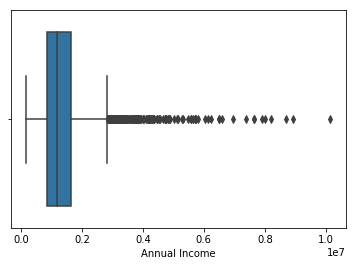

Tax Liens


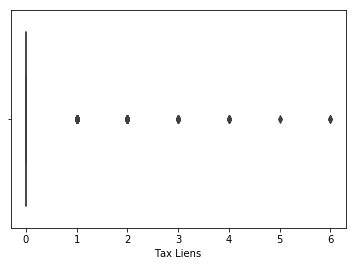

Number of Open Accounts


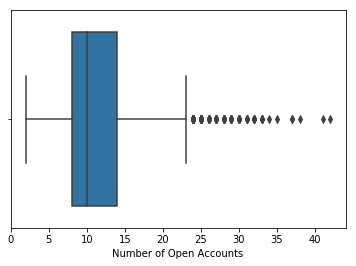

Years of Credit History


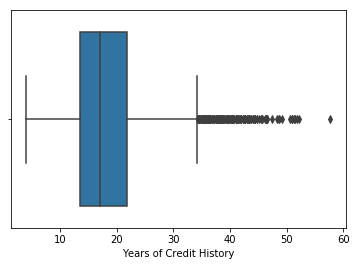

Maximum Open Credit


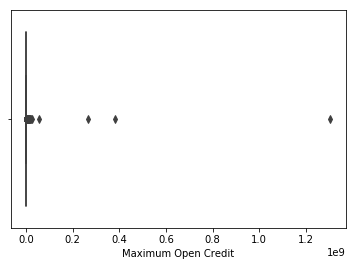

Number of Credit Problems


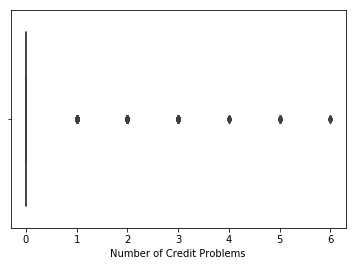

Months since last delinquent


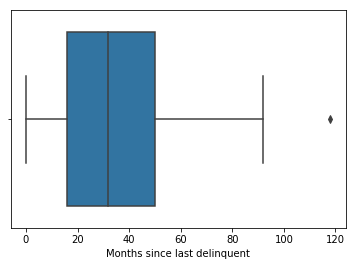

Bankruptcies


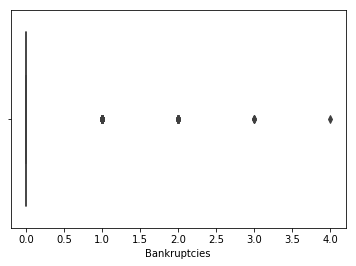

Current Loan Amount


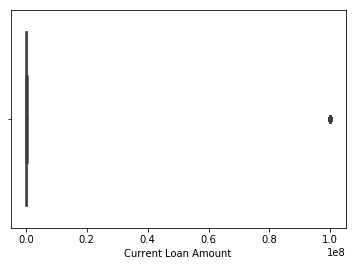

Current Credit Balance


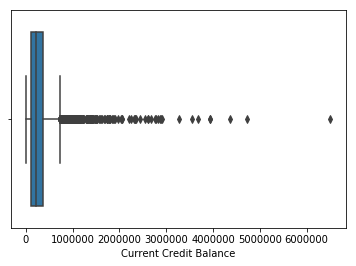

Monthly Debt


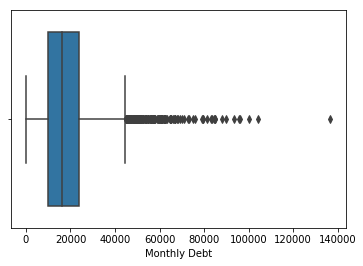

Credit Score


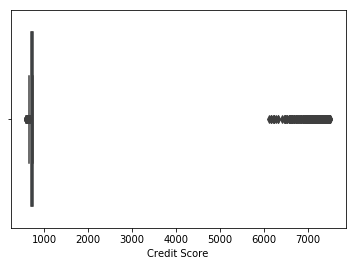

Credit Default


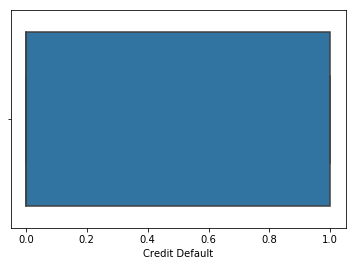

In [18]:
for colname in not_obj_col:
    print(colname)
    sns.boxplot(train[colname])
    plt.show()

In [19]:
train[train['Bankruptcies'].isnull()].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
3063,Rent,464474.0,10+ years,0.0,5.0,14.9,38126.0,0.0,0.0,NaN,other,Short Term,44814.0,18373.0,929.0,7490.0,1
3401,Rent,326154.0,6 years,0.0,2.0,19.1,0.0,0.0,77.0,NaN,other,Short Term,99999999.0,0.0,1245.0,712.0,0
7379,Own Home,290415.0,< 1 year,0.0,16.0,12.5,116644.0,0.0,0.0,NaN,small business,Short Term,71170.0,55499.0,2953.0,7160.0,1
100,Own Home,337079.0,1 year,0.0,9.0,39.6,644204.0,0.0,0.0,NaN,educational expenses,Short Term,99999999.0,224770.0,4326.0,734.0,0
898,Rent,739005.0,2 years,0.0,20.0,18.3,2177758.0,0.0,0.0,NaN,debt consolidation,Short Term,456808.0,607487.0,9669.0,732.0,1


Заменим пропуски медианным значением.

In [20]:
median_bankruptcies = train['Bankruptcies'].median()

In [21]:
train.loc[train['Annual Income'] > 5*10**6, :].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
5774,Home Mortgage,7655480.0,10+ years,0.0,12.0,10.8,1837616.0,0.0,NaN,0.0,debt consolidation,Short Term,443212.0,766536.0,43062.0,735.0,0
4491,Home Mortgage,8200229.0,2 years,0.0,11.0,16.7,333630.0,0.0,29.0,0.0,debt consolidation,Short Term,117040.0,116128.0,8610.0,7440.0,1
7089,Rent,5759280.0,7 years,0.0,27.0,27.2,3930212.0,0.0,NaN,0.0,debt consolidation,Short Term,664642.0,967366.0,57593.0,742.0,0
3446,Home Mortgage,6611810.0,10+ years,0.0,13.0,37.6,1387320.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,788386.0,36475.0,748.0,0
602,Home Mortgage,5631030.0,1 year,0.0,5.0,17.5,0.0,0.0,NaN,0.0,home improvements,Short Term,99999999.0,60439.0,15485.0,743.0,0


Значение **'Annual Income' > 5*10^6** явно является выбросом. Заменим его на медианное значение.

In [22]:
median_annual_income = train['Annual Income'].median()

In [23]:
train.loc[train['Number of Open Accounts'] > 30, :].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
2689,Rent,NaN,10+ years,0.0,32.0,36.4,2020656.0,0.0,NaN,0.0,other,Short Term,105600.0,57589.0,30297.0,NaN,0
305,Rent,NaN,< 1 year,0.0,32.0,9.0,96668.0,0.0,75.0,0.0,other,Short Term,75262.0,47424.0,1870.0,NaN,0
6868,Rent,2268011.0,6 years,1.0,37.0,15.1,2733544.0,1.0,NaN,0.0,debt consolidation,Long Term,247170.0,535895.0,37611.0,731.0,0
3874,Home Mortgage,1572858.0,10+ years,0.0,31.0,19.9,1634864.0,0.0,66.0,0.0,debt consolidation,Short Term,99999999.0,652308.0,15204.0,742.0,0
6842,Rent,691087.0,1 year,0.0,34.0,14.8,774202.0,0.0,NaN,0.0,debt consolidation,Short Term,239470.0,363071.0,16817.0,694.0,1


Значение **'Number of Open Accounts' > 30** явно является выбросом. Заменим его на медианное значение.

In [24]:
median_accounts = train['Number of Open Accounts'].median()

In [25]:
train.loc[train['Years of Credit History'] > 45, :].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
4716,Rent,NaN,NaN,0.0,5.0,51.5,485672.0,0.0,14.0,0.0,debt consolidation,Long Term,614614.0,416518.0,16541.0,NaN,1
5636,Home Mortgage,2331528.0,4 years,0.0,15.0,49.1,710050.0,0.0,NaN,0.0,home improvements,Short Term,562430.0,193173.0,26813.0,749.0,0
6241,Home Mortgage,NaN,10+ years,0.0,11.0,46.5,934274.0,0.0,NaN,0.0,debt consolidation,Long Term,703076.0,585789.0,19108.0,NaN,0
476,Home Mortgage,1076768.0,NaN,0.0,14.0,57.7,432124.0,0.0,24.0,0.0,debt consolidation,Long Term,558360.0,186219.0,13818.0,667.0,1
3165,Own Home,2231759.0,10+ years,0.0,22.0,46.1,1083192.0,0.0,34.0,0.0,debt consolidation,Short Term,786478.0,721240.0,40544.0,680.0,0


Значение **'Years of Credit History' > 45** явно является выбросом. Заменим его на медианное значение.

In [26]:
median_years_history = train['Years of Credit History'].median()

In [27]:
train.loc[train['Maximum Open Credit'] > 10**7, :].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
4840,Home Mortgage,1687599.0,5 years,0.0,17.0,17.1,10201598.0,0.0,21.0,0.0,debt consolidation,Short Term,99999999.0,2784108.0,26298.0,735.0,0
2617,Home Mortgage,3217802.0,10+ years,0.0,12.0,35.5,265512874.0,0.0,NaN,0.0,other,Short Term,50116.0,1834450.0,20272.0,750.0,0
4745,Own Home,6029954.0,4 years,0.0,30.0,17.5,11603856.0,0.0,NaN,0.0,debt consolidation,Short Term,753588.0,4720132.0,136679.0,745.0,0
44,Have Mortgage,1334256.0,10+ years,0.0,17.0,15.4,380052288.0,1.0,35.0,0.0,take a trip,Short Term,33110.0,656450.0,34357.0,729.0,0
5523,Home Mortgage,1520304.0,10+ years,0.0,21.0,35.5,21372428.0,0.0,0.0,0.0,other,Long Term,99999999.0,1975012.0,12555.0,728.0,0


Значение **'Maximum Open Credit' > 2*10^7** явно является выбросом. Заменим его на медианное значение.

In [28]:
median_max_credit = train['Maximum Open Credit'].median()

In [29]:
train.loc[train['Months since last delinquent'] > 100, :].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
4191,Home Mortgage,3009201.0,6 years,0.0,10.0,20.8,773322.0,0.0,118.0,0.0,debt consolidation,Short Term,449592.0,299877.0,15297.0,738.0,0


Значение **'Months since last delinquent' > 100** явно является выбросом. Заменим его на медианное значение.

In [30]:
median_months_delinquent = train['Months since last delinquent'].median()

In [31]:
train.loc[train['Current Credit Balance'] > 3*10**6, :].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
162,Home Mortgage,2131591.0,< 1 year,0.0,15.0,31.7,4191176.0,0.0,NaN,0.0,debt consolidation,Short Term,269258.0,3547262.0,20783.0,728.0,0
4745,Own Home,6029954.0,4 years,0.0,30.0,17.5,11603856.0,0.0,NaN,0.0,debt consolidation,Short Term,753588.0,4720132.0,136679.0,745.0,0
2618,Home Mortgage,3199448.0,10+ years,0.0,11.0,26.3,5109676.0,0.0,71.0,0.0,debt consolidation,Short Term,767228.0,3927471.0,31461.0,715.0,0
3198,Home Mortgage,NaN,10+ years,0.0,14.0,26.9,5150860.0,0.0,49.0,0.0,home improvements,Short Term,163680.0,3683340.0,75910.0,NaN,0
3316,Home Mortgage,NaN,9 years,0.0,17.0,28.4,6619316.0,0.0,NaN,0.0,debt consolidation,Long Term,522874.0,3944514.0,65905.0,NaN,1


Значение **'Current Credit Balance' > 3*10^6** явно является выбросом. Заменим его на медианное значение.

In [32]:
median_current_credit_balance = train['Current Credit Balance'].median()

In [33]:
train.loc[train['Monthly Debt'] > 70000, :].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
7459,Home Mortgage,NaN,9 years,3.0,21.0,12.1,1547854.0,3.0,37.0,0.0,debt consolidation,Short Term,458854.0,1149614.0,85030.0,NaN,0
1472,Home Mortgage,3234199.0,8 years,0.0,14.0,28.2,878856.0,0.0,1.0,0.0,debt consolidation,Short Term,616792.0,534356.0,84359.0,742.0,1
7478,Home Mortgage,3888160.0,6 years,0.0,30.0,16.3,1435456.0,0.0,21.0,0.0,debt consolidation,Short Term,787864.0,402914.0,93640.0,703.0,0
2535,Home Mortgage,4120226.0,10+ years,0.0,15.0,13.0,3931620.0,0.0,NaN,0.0,debt consolidation,Long Term,542146.0,2889577.0,104036.0,656.0,1
4745,Own Home,6029954.0,4 years,0.0,30.0,17.5,11603856.0,0.0,NaN,0.0,debt consolidation,Short Term,753588.0,4720132.0,136679.0,745.0,0


Значение **'Monthly Debt' > 70 000** явно является выбросом. Заменим его на медианное значение.

In [34]:
median_monthly_debt = train['Monthly Debt'].median()

## Применение функции по изменению данных. Тренировочная выборка.

In [35]:
modify_data(train, median_annual_income, median_accounts, median_months_delinquent, median_years_history, median_max_credit, 
            median_current_credit_balance, median_monthly_debt, median_bankruptcies)

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


Заменим пропущенные значения поля `Credit Score`

In [36]:
null_credit_score = train[train['Credit Score'].isnull()].index
not_null__credit_score = train[train['Credit Score'].notnull()].index

In [37]:
null_credit_score

Int64Index([4716,  532, 2140, 1393,  481, 1499, 4521, 2351, 5176, 2301,
            ...
            6418, 1765, 6266, 1789,  829,  447, 6655,   48,  772, 7113],
           dtype='int64', length=1186)

In [38]:
not_null__credit_score

Int64Index([4864, 7199, 2560, 3474, 4290, 7465,  533, 6748, 3725, 5006,
            ...
            1646,  840, 4298, 6897, 4706, 6844, 1144, 6512, 5944, 5327],
           dtype='int64', length=4439)

In [39]:
y_train_credit = train.loc[not_null__credit_score, :]
y_train_credit = y_train_credit['Credit Score']
X_train_credit = train.loc[not_null__credit_score, :]
X_train_credit = X_train_credit.drop('Credit Score', axis=1)
X_train_credit = X_train_credit[['Bankruptcies', 'Number of Credit Problems', 'Maximum Open Credit', 'Years of Credit History', 'Number of Open Accounts']]

In [40]:
X_test_credit = train.loc[null_credit_score, :]
X_test_credit = X_test_credit.drop('Credit Score', axis=1)
X_test_credit = X_test_credit[['Bankruptcies', 'Number of Credit Problems', 'Maximum Open Credit', 'Years of Credit History', 'Number of Open Accounts']]

In [41]:
parameters = {'n_estimators': [150, 200, 250],
              'max_features': np.arange(3, 6),
              'max_depth': np.arange(7, 10)}

clf_credit = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                   param_grid=parameters,
                   scoring='r2',
                   cv=4)

In [42]:
clf_credit.fit(X_train_credit, y_train_credit)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [150, 200, 250], 'max_features': array([3, 4, 5]), 'max_depth': array([7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [43]:
clf_credit.best_params_

{'max_depth': 7, 'max_features': 3, 'n_estimators': 250}

In [44]:
clf_credit = RandomForestRegressor(max_depth=7, max_features=3, n_estimators=250)
clf_credit.fit(X_train_credit, y_train_credit)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=250, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [45]:
y_test_credit = clf_credit.predict(X_test_credit)
y_test_credit

array([1125.07968854, 1899.43893571, 1428.29621943, ..., 1213.22965831,
       1227.27684193, 1198.58223791])

In [46]:
train.loc[null_credit_score, 'Credit Score'] = y_test_credit

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [47]:
train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Short Term
count,4.439000e+03,5625.000000,5625.000000,5625.000000,5.625000e+03,5625.000000,2569.000000,5625.000000,5.625000e+03,5.625000e+03,5625.000000,5625.000000,5625.000000,5625.000000
mean,1.327452e+06,0.030044,11.058667,18.211200,6.431799e+05,0.166044,34.626703,0.112889,1.177759e+07,2.836054e+05,18074.886044,1151.864495,0.280711,0.740622
std,7.011857e+05,0.264657,4.722654,6.821262,6.720867e+05,0.488654,21.560382,0.336103,3.180890e+07,2.779822e+05,11184.390413,1432.174682,0.449387,0.438332
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,2.147200e+04,0.000000e+00,0.000000,585.000000,0.000000,0.000000
25%,8.401325e+05,0.000000,8.000000,13.500000,2.801700e+05,0.000000,16.000000,0.000000,1.814340e+05,1.140950e+05,10039.000000,718.000000,0.000000,0.000000
50%,1.171920e+06,0.000000,10.000000,17.000000,4.819100e+05,0.000000,32.000000,0.000000,3.111020e+05,2.092850e+05,16087.000000,738.000000,0.000000,1.000000
75%,1.626932e+06,0.000000,14.000000,21.700000,7.905480e+05,0.000000,50.000000,0.000000,5.265700e+05,3.587390e+05,23716.000000,917.787020,1.000000,1.000000
max,4.906028e+06,6.000000,30.000000,44.800000,9.541136e+06,6.000000,92.000000,4.000000,1.000000e+08,2.913707e+06,69413.000000,7510.000000,1.000000,1.000000


In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5625 entries, 4864 to 7113
Data columns (total 18 columns):
Home Ownership                  5625 non-null object
Annual Income                   4439 non-null float64
Years in current job            5348 non-null object
Tax Liens                       5625 non-null float64
Number of Open Accounts         5625 non-null float64
Years of Credit History         5625 non-null float64
Maximum Open Credit             5625 non-null float64
Number of Credit Problems       5625 non-null float64
Months since last delinquent    2569 non-null float64
Bankruptcies                    5625 non-null float64
Purpose                         5625 non-null object
Term                            5625 non-null object
Current Loan Amount             5625 non-null float64
Current Credit Balance          5625 non-null float64
Monthly Debt                    5625 non-null float64
Credit Score                    5625 non-null float64
Credit Default                

In [49]:
train.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'Short Term'],
      dtype='object')

In [50]:
features = ['Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
            'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies',
            'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
            'Short Term', 'Credit Score']

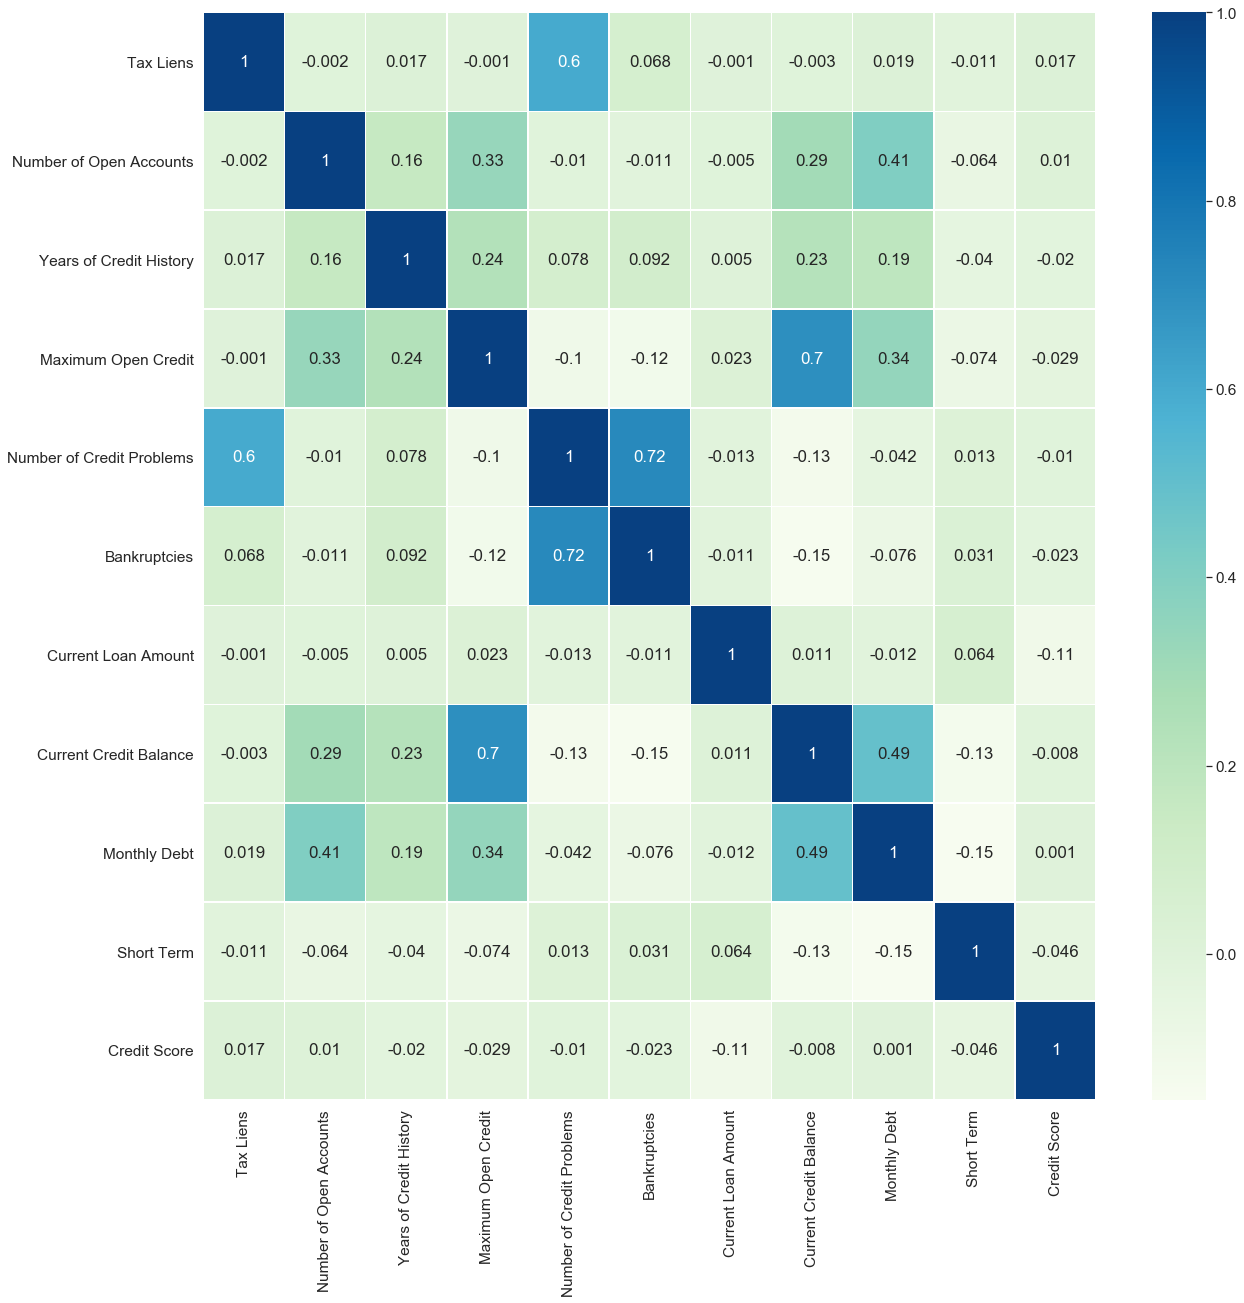

In [51]:
plt.figure(figsize=(20,20))

sns.set(font_scale=1.4)
sns.heatmap(train[features].corr().round(3),annot=True, linewidths=0.5, cmap='GnBu')

In [52]:
train_balanced = get_balance(train, 'Credit Default')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  


In [53]:
train_balanced['Credit Default'].value_counts()

0    4046
1    3158
Name: Credit Default, dtype: int64

In [54]:
y_train = train_balanced['Credit Default']
X_train = train_balanced[features]

In [55]:
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=features)

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [56]:
pca_1 = PCA(n_components=1, random_state=31)
X_train['Bankruptcies - Number of Problems'] = pca_1.fit_transform(X_train[['Bankruptcies', 'Number of Credit Problems']])

In [57]:
pca_2 = PCA(n_components=1, random_state=31)
X_train['Maximum Open Credit - Current Cr Balance'] = pca_2.fit_transform(X_train[['Maximum Open Credit', 'Current Credit Balance']])

Создаем кластеры

In [58]:
cluster_feauters = ['Tax Liens', 'Credit Score']

Text(0.5, 1.0, 'Inertia')

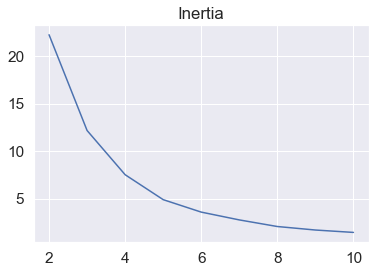

In [59]:
inertias = []

for i in range(2, 11):
    temp_model = KMeans(n_clusters=i, random_state=42)
    temp_model.fit(X_train[cluster_feauters])
    
    temp_inertia = temp_model.inertia_
    
    inertias.append(temp_inertia)
    
plt.plot(range(2, 11), inertias)

plt.title('Inertia')

In [60]:
model = KMeans(n_clusters=4, random_state=42)
labels = model.fit_predict(X_train[cluster_feauters])
labels

array([3, 3, 3, ..., 3, 3, 3])

Text(0, 0.5, 'Credit Score')

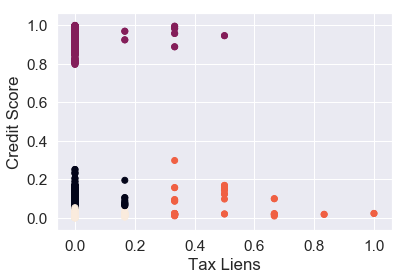

In [61]:
plt.scatter(X_train[cluster_feauters[0]], X_train[cluster_feauters[1]], c=labels)

plt.xlabel(cluster_feauters[0])
plt.ylabel(cluster_feauters[1])

In [62]:
cluster_name = cluster_feauters[0] + ' ' + cluster_feauters[1]
model = AgglomerativeClustering(n_clusters=4)
X_train[cluster_name] = model.fit_predict(X_train[cluster_feauters])

Text(0, 0.5, 'Credit Score')

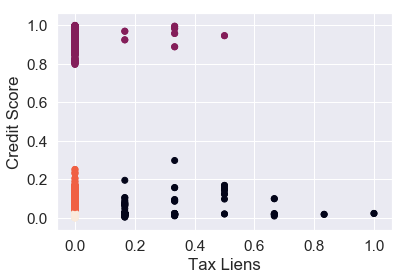

In [63]:
plt.scatter(X_train[cluster_feauters[0]], X_train[cluster_feauters[1]], c=X_train[cluster_name])

plt.xlabel(cluster_feauters[0])
plt.ylabel(cluster_feauters[1])

In [64]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train[cluster_feauters], X_train[cluster_name])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')

In [65]:
X_train[cluster_name] = X_train[cluster_name].astype(object)
X_train = pd.get_dummies(X_train)

In [66]:
pca_3 = PCA(n_components=1, random_state=31)
X_train['Tax Liens - Tax Liens Credit Score_0'] = pca_3.fit_transform(X_train[['Tax Liens', 'Tax Liens Credit Score_0']])

In [67]:
pca_4 = PCA(n_components=1, random_state=31)
X_train['Credit Score - Tax Liens Credit Score_1'] = pca_4.fit_transform(X_train[['Credit Score', 'Tax Liens Credit Score_1']])

In [68]:
pca_5 = PCA(n_components=1, random_state=31)
X_train['Tax Liens Credit Score_2 - Tax Liens Credit Score_3'] = pca_5.fit_transform(X_train[['Tax Liens Credit Score_2', 'Tax Liens Credit Score_3']])

In [69]:
X_train.columns

Index(['Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Short Term', 'Credit Score', 'Bankruptcies - Number of Problems',
       'Maximum Open Credit - Current Cr Balance', 'Tax Liens Credit Score_0',
       'Tax Liens Credit Score_1', 'Tax Liens Credit Score_2',
       'Tax Liens Credit Score_3', 'Tax Liens - Tax Liens Credit Score_0',
       'Credit Score - Tax Liens Credit Score_1',
       'Tax Liens Credit Score_2 - Tax Liens Credit Score_3'],
      dtype='object')

In [70]:
new_features = ['Number of Open Accounts', 'Years of Credit History',
                'Maximum Open Credit - Current Cr Balance', 'Bankruptcies - Number of Problems',
                'Current Loan Amount', 'Monthly Debt',
                'Short Term', 
                'Tax Liens - Tax Liens Credit Score_0', 'Credit Score - Tax Liens Credit Score_1',
                'Tax Liens Credit Score_2 - Tax Liens Credit Score_3']

In [71]:
len(new_features)

10

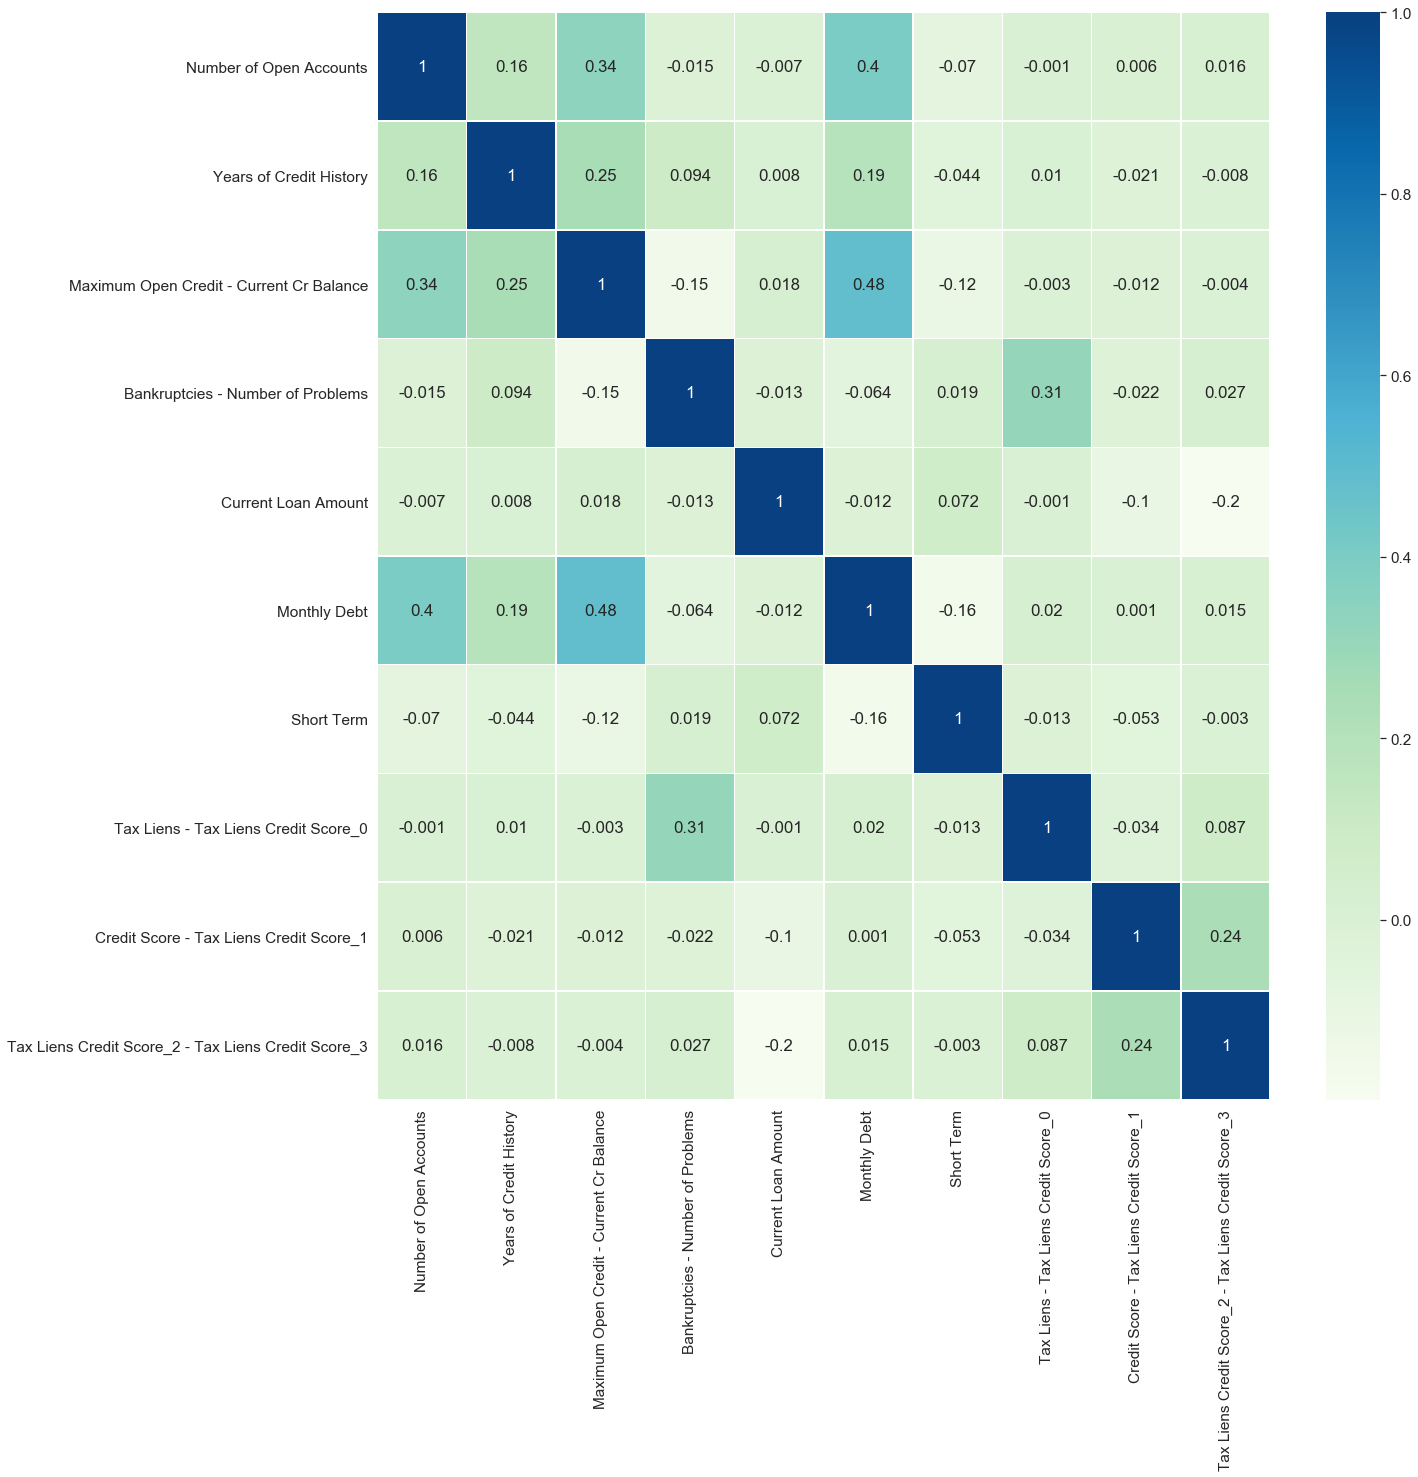

In [72]:
plt.figure(figsize=(20,20))

sns.set(font_scale=1.4)
sns.heatmap(X_train[new_features].corr().round(3),annot=True, linewidths=0.5, cmap='GnBu')

Обучаем модель

In [114]:
parameters = {'n_estimators': [200, 250, 300],
              'max_features': np.arange(9, 11),
              'max_depth': np.arange(8, 10)}

clf = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                   param_grid=parameters,
                   scoring='f1',
                   cv=4)

In [115]:
clf.fit(X_train[new_features], y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [200, 250, 300], 'max_features': array([ 9, 10]), 'max_depth': array([8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [116]:
clf.best_params_

{'max_depth': 9, 'max_features': 9, 'n_estimators': 250}

In [117]:
clf_rf = RandomForestClassifier(max_depth=9, max_features=9, n_estimators=250)
clf_rf.fit(X_train[new_features], y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features=9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

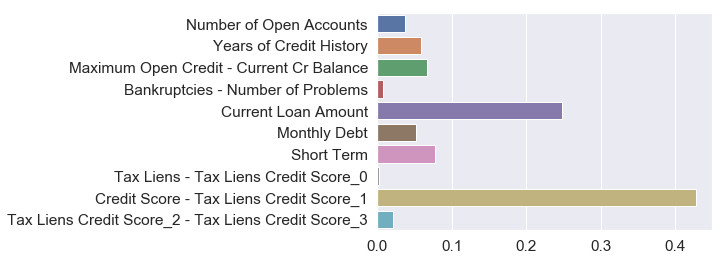

In [118]:
sns.barplot(clf_rf.feature_importances_, X_train[new_features].columns)

In [119]:
y_train_pred = clf_rf.predict(X_train[new_features])

In [120]:
y_train_pred_proba = clf_rf.predict_proba(X_train[new_features])

## Применение функции по изменению данных. Валидационная выборка.

In [85]:
modify_data(valid, median_annual_income, median_accounts, median_months_delinquent, median_years_history, median_max_credit, 
            median_current_credit_balance, median_monthly_debt, median_bankruptcies)

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [86]:
null_credit_score = valid[valid['Credit Score'].isnull()].index
not_null__credit_score = valid[valid['Credit Score'].notnull()].index

In [87]:
null_credit_score

Int64Index([6079, 3858, 1386, 5290, 5098, 3900, 7073,  512, 6214, 7442,
            ...
            3482,  817, 3712,  722, 6761, 3214, 6369, 1139, 5918, 1271],
           dtype='int64', length=371)

In [88]:
not_null__credit_score

Int64Index([6322, 5231, 5360, 3518,  921, 1315, 3123, 7097, 5846, 2596,
            ...
            2430, 3045, 5125, 7438, 2716, 2658, 4259, 1909, 1001, 6992],
           dtype='int64', length=1504)

In [89]:
X_test_credit = valid.loc[null_credit_score, :]
X_test_credit = X_test_credit.drop('Credit Score', axis=1)
X_test_credit = X_test_credit[['Bankruptcies', 'Number of Credit Problems', 'Maximum Open Credit', 'Years of Credit History', 'Number of Open Accounts']]

In [90]:
y_test_credit = clf_credit.predict(X_test_credit)

In [91]:
valid.loc[null_credit_score, 'Credit Score'] = y_test_credit

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [92]:
y_valid = valid['Credit Default']
X_valid = valid[features]

In [93]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1875 entries, 6079 to 6992
Data columns (total 11 columns):
Tax Liens                    1875 non-null float64
Number of Open Accounts      1875 non-null float64
Years of Credit History      1875 non-null float64
Maximum Open Credit          1875 non-null float64
Number of Credit Problems    1875 non-null float64
Bankruptcies                 1875 non-null float64
Current Loan Amount          1875 non-null float64
Current Credit Balance       1875 non-null float64
Monthly Debt                 1875 non-null float64
Short Term                   1875 non-null int32
Credit Score                 1875 non-null float64
dtypes: float64(10), int32(1)
memory usage: 248.5 KB


In [94]:
valid['Credit Default'].value_counts()

0    1341
1     534
Name: Credit Default, dtype: int64

In [95]:
X_valid.describe()

,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Short Term,Credit Score
count,1875.000000,1875.000000,1875.000000,1.875000e+03,1875.000000,1875.000000,1.875000e+03,1.875000e+03,1875.000000,1875.000000,1875.000000
mean,0.030400,11.002667,18.182240,6.438912e+05,0.181867,0.129067,1.215993e+07,2.870049e+05,17923.126400,0.741333,1145.619697
std,0.291527,4.669378,6.745487,6.812635e+05,0.527263,0.377294,3.228209e+07,2.916500e+05,10873.679247,0.438019,1426.287963
min,0.000000,2.000000,5.000000,0.000000e+00,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,0.000000,588.000000
25%,0.000000,8.000000,13.500000,2.766940e+05,0.000000,0.000000,1.783320e+05,1.151210e+05,10198.500000,0.000000,718.000000
50%,0.000000,10.000000,17.000000,4.711300e+05,0.000000,0.000000,3.021480e+05,2.095130e+05,15960.000000,1.000000,738.000000
75%,0.000000,14.000000,21.900000,7.888540e+05,0.000000,0.000000,4.986630e+05,3.577795e+05,23419.000000,1.000000,828.698377
max,7.000000,30.000000,44.700000,9.339924e+06,7.000000,4.000000,1.000000e+08,2.759503e+06,65167.000000,1.000000,7510.000000


In [96]:
X_valid = pd.DataFrame(scaler.transform(X_valid), columns=features)

In [97]:
X_valid['Bankruptcies - Number of Problems'] = pca_1.transform(X_valid[['Bankruptcies', 'Number of Credit Problems']])

In [98]:
X_valid['Maximum Open Credit - Current Cr Balance'] = pca_2.transform(X_valid[['Maximum Open Credit', 'Current Credit Balance']])

Работа с кластерами

In [99]:
X_valid[cluster_name] = knn.predict(X_valid[cluster_feauters])

In [100]:
X_valid[cluster_name] = X_valid[cluster_name].astype(object)
X_valid = pd.get_dummies(X_valid)

In [101]:
X_valid['Tax Liens - Tax Liens Credit Score_0'] = pca_3.transform(X_valid[['Tax Liens', 'Tax Liens Credit Score_0']])

In [102]:
X_valid['Credit Score - Tax Liens Credit Score_1'] = pca_4.transform(X_valid[['Credit Score', 'Tax Liens Credit Score_1']])

In [103]:
X_valid['Tax Liens Credit Score_2 - Tax Liens Credit Score_3'] = pca_5.transform(X_valid[['Tax Liens Credit Score_2', 'Tax Liens Credit Score_3']])

Предсказание

In [121]:
y_valid_pred = clf_rf.predict(X_valid[new_features])
pd.DataFrame(y_valid_pred)[0].value_counts()

0    1447
1     428
Name: 0, dtype: int64

In [122]:
y_valid_pred_proba = clf_rf.predict_proba(X_valid[new_features])

In [123]:
get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.92      0.83      4046
           1       0.86      0.61      0.72      3158

   micro avg       0.79      0.79      0.79      7204
   macro avg       0.81      0.77      0.77      7204
weighted avg       0.80      0.79      0.78      7204

TEST

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1341
           1       0.57      0.45      0.50       534

   micro avg       0.75      0.75      0.75      1875
   macro avg       0.68      0.66      0.67      1875
weighted avg       0.73      0.75      0.74      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1155  186
1                292  242


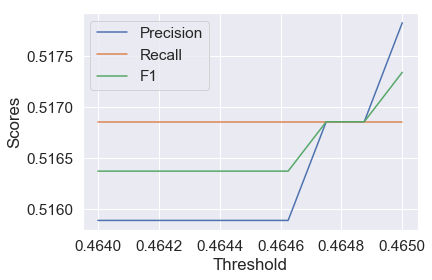

In [124]:
show_proba_calibration(y_valid_pred_proba[:,1], y_valid, 0.464, 0.465)

In [125]:
y_p = np.array((y_valid_pred_proba[:,1] > 0.4648).astype('int'))
pd.DataFrame(y_p)[0].value_counts()

0    1341
1     534
Name: 0, dtype: int64

In [126]:
get_classification_report(y_train, y_train_pred, y_valid, y_p)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.92      0.83      4046
           1       0.86      0.61      0.72      3158

   micro avg       0.79      0.79      0.79      7204
   macro avg       0.81      0.77      0.77      7204
weighted avg       0.80      0.79      0.78      7204

TEST

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1341
           1       0.52      0.52      0.52       534

   micro avg       0.72      0.72      0.72      1875
   macro avg       0.66      0.66      0.66      1875
weighted avg       0.72      0.72      0.72      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1083  258
1                258  276


## Обучаем итоговую модель на изначальной выборке

In [127]:
modify_data(data, median_annual_income, median_accounts, median_months_delinquent, median_years_history, median_max_credit, 
            median_current_credit_balance, median_monthly_debt, median_bankruptcies)

In [128]:
null_credit_score = data[data['Credit Score'].isnull()].index
not_null__credit_score = data[data['Credit Score'].notnull()].index

In [129]:
null_credit_score

Int64Index([   5,    8,    9,   10,   16,   23,   24,   29,   33,   35,
            ...
            7442, 7451, 7453, 7459, 7470, 7482, 7492, 7494, 7498, 7499],
           dtype='int64', length=1557)

In [130]:
not_null__credit_score

Int64Index([   0,    1,    2,    3,    4,    6,    7,   11,   12,   13,
            ...
            7486, 7487, 7488, 7489, 7490, 7491, 7493, 7495, 7496, 7497],
           dtype='int64', length=5943)

In [131]:
y_train_credit = data.loc[not_null__credit_score, :]
y_train_credit = y_train_credit['Credit Score']
X_train_credit = data.loc[not_null__credit_score, :]
X_train_credit = X_train_credit.drop('Credit Score', axis=1)
X_train_credit = X_train_credit[['Bankruptcies', 'Number of Credit Problems', 'Maximum Open Credit', 'Years of Credit History', 'Number of Open Accounts']]

In [132]:
clf_credit = RandomForestRegressor(max_depth=7, max_features=3, n_estimators=250)
clf_credit.fit(X_train_credit, y_train_credit)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=250, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [133]:
X_test_credit = data.loc[null_credit_score, :]
X_test_credit = X_test_credit.drop('Credit Score', axis=1)
X_test_credit = X_test_credit[['Bankruptcies', 'Number of Credit Problems', 'Maximum Open Credit', 'Years of Credit History', 'Number of Open Accounts']]

In [134]:
y_test_credit = clf_credit.predict(X_test_credit)
y_test_credit

array([1294.50320376, 2056.78254785, 1098.80982475, ..., 1209.44267408,
        969.90613854, 1345.92272385])

In [135]:
data.loc[null_credit_score, 'Credit Score'] = y_test_credit

In [136]:
data = get_balance(data, 'Credit Default')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  


In [137]:
data['Credit Default'].value_counts()

0    5387
1    4226
Name: Credit Default, dtype: int64

In [138]:
y = data['Credit Default']
X = data[features]

In [139]:
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=features)

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [140]:
pca_1 = PCA(n_components=1, random_state=31)
X['Bankruptcies - Number of Problems'] = pca_1.fit_transform(X[['Bankruptcies', 'Number of Credit Problems']])

In [141]:
pca_2 = PCA(n_components=1, random_state=31)
X['Maximum Open Credit - Current Cr Balance'] = pca_2.fit_transform(X[['Maximum Open Credit', 'Current Credit Balance']])

Создаем кластеры

In [142]:
model = KMeans(n_clusters=4, random_state=42)
labels = model.fit_predict(X[cluster_feauters])
labels

array([2, 0, 0, ..., 0, 0, 0])

In [143]:
model = AgglomerativeClustering(n_clusters=4)
X[cluster_name] = model.fit_predict(X[cluster_feauters])

In [144]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X[cluster_feauters], X[cluster_name])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')

In [145]:
X[cluster_name] = X[cluster_name].astype(object)
X = pd.get_dummies(X)

In [146]:
pca_3 = PCA(n_components=1, random_state=31)
X['Tax Liens - Tax Liens Credit Score_0'] = pca_3.fit_transform(X[['Tax Liens', 'Tax Liens Credit Score_0']])

In [147]:
pca_4 = PCA(n_components=1, random_state=31)
X['Credit Score - Tax Liens Credit Score_1'] = pca_4.fit_transform(X[['Credit Score', 'Tax Liens Credit Score_1']])

In [148]:
pca_5 = PCA(n_components=1, random_state=31)
X['Tax Liens Credit Score_2 - Tax Liens Credit Score_3'] = pca_5.fit_transform(X[['Tax Liens Credit Score_2', 'Tax Liens Credit Score_3']])

In [150]:
clf_rf = RandomForestClassifier(max_depth=9, max_features=9, n_estimators=250)
clf_rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features=9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Подготовка тестого датасета и предсказание значений.

In [151]:
modify_data(X_test, median_annual_income, median_accounts, median_months_delinquent, median_years_history, median_max_credit, 
            median_current_credit_balance, median_monthly_debt, median_bankruptcies)

In [152]:
null_credit_score = X_test[X_test['Credit Score'].isnull()].index
not_null__credit_score = X_test[X_test['Credit Score'].notnull()].index

In [153]:
null_credit_score

Int64Index([   0,    8,   16,   20,   27,   31,   35,   37,   38,   42,
            ...
            2443, 2448, 2458, 2462, 2465, 2469, 2475, 2479, 2487, 2496],
           dtype='int64', length=513)

In [154]:
not_null__credit_score

Int64Index([   1,    2,    3,    4,    5,    6,    7,    9,   10,   11,
            ...
            2489, 2490, 2491, 2492, 2493, 2494, 2495, 2497, 2498, 2499],
           dtype='int64', length=1987)

In [155]:
X_test_credit = X_test.loc[null_credit_score, :]
X_test_credit = X_test_credit.drop('Credit Score', axis=1)
X_test_credit = X_test_credit[['Bankruptcies', 'Number of Credit Problems', 'Maximum Open Credit', 'Years of Credit History', 'Number of Open Accounts']]

In [156]:
y_test_credit = clf_credit.predict(X_test_credit)

In [157]:
X_test.loc[null_credit_score, 'Credit Score'] = y_test_credit

In [158]:
X_test = X_test[features]

In [159]:
X_test = pd.DataFrame(scaler.transform(X_test), columns=features)

In [160]:
X_test['Bankruptcies - Number of Problems'] = pca_1.transform(X_test[['Bankruptcies', 'Number of Credit Problems']])

In [161]:
X_test['Maximum Open Credit - Current Cr Balance'] = pca_2.transform(X_test[['Maximum Open Credit', 'Current Credit Balance']])

Работа с кластерами

In [162]:
X_test[cluster_name] = knn.predict(X_test[cluster_feauters])

In [163]:
X_test[cluster_name] = X_test[cluster_name].astype(object)
X_test = pd.get_dummies(X_test)

In [164]:
X_test['Tax Liens - Tax Liens Credit Score_0'] = pca_3.transform(X_test[['Tax Liens', 'Tax Liens Credit Score_0']])

In [165]:
X_test['Credit Score - Tax Liens Credit Score_1'] = pca_4.transform(X_test[['Credit Score', 'Tax Liens Credit Score_1']])

In [166]:
X_test['Tax Liens Credit Score_2 - Tax Liens Credit Score_3'] = pca_5.transform(X_test[['Tax Liens Credit Score_2', 'Tax Liens Credit Score_3']])

In [167]:
y_test = clf_rf.predict(X_test)

In [168]:
y_test_proba = clf_rf.predict_proba(X_test)

In [169]:
y_test = np.array((y_valid_pred_proba[:,1] > 0.4648).astype('int'))

In [170]:
y_test = pd.DataFrame(y_test, columns=['Credit Default'])

In [171]:
y_test.head()

,Credit Default
0,0
1,0
2,1
3,0
4,0


In [172]:
y_test['Credit Default'].value_counts()

0    1341
1     534
Name: Credit Default, dtype: int64

In [174]:
y_test.to_csv('IYakovleva_predictions.csv', index=None)